In [1]:
from datetime import datetime
import os

import requests
from PIL import Image
import io
import numpy as np
from skimage.color import rgb2gray
import urllib.parse


In [2]:
los_angeles = [
    {'n': 34.269260, 'w': -118.604202, 's': 34.171040, 'e': -118.370722},
    {'n': 34.100406, 'w': -118.362530, 's': 33.797995, 'e': -117.863483},
    {'n': 33.714559, 'w': -118.033473, 's': 33.636157, 'e': -117.746060}
]

chicago = [
    {'n': 42.072123, 'w': -88.311501, 's': 41.643560, 'e': -87.682533}
]

houston = [
    {'n': 29.875249, 'w': -95.563377, 's': 29.610542, 'e': -95.189842}
]

phoenix = [
    {'n': 33.688554, 'w': -112.381892, 's': 33.392095, 'e': -111.887507}
]

philadelphia = [
    {'n': 40.052889, 'w': -75.233393, 's': 39.904511, 'e': -75.140009},
    {'n': 40.049736, 'w': -75.144129, 's': 40.026079, 'e': -75.027399}
]

san_francisco = [
    {'n': 37.801910, 'w': -122.506267, 's': 37.737590, 'e': -122.398120},
    {'n': 37.826862, 'w': -122.295123, 's': 37.800282, 'e': -122.255984}
]

boston = [
    {'n': 42.387338, 'w': -71.141267, 's': 42.283792, 'e': -71.046510}
]

cities_boxes = [los_angeles, chicago, houston, phoenix, philadelphia, san_francisco, boston]

In [3]:
def pick_random_center_from_city(city_boxes):
    index = np.random.randint(len(city_boxes))
    box = city_boxes[index]

    rand_x = np.random.uniform(box['w'], box['e'])
    rand_y = np.random.uniform(box['n'], box['s'])

    return rand_x, rand_y

def pick_random_center(cities_boxes):
    city_nr = np.random.randint(len(cities_boxes)) #pick a city
    return pick_random_center_from_city(cities_boxes[city_nr])

In [4]:
GOOGLE_API_KEY=os.environ['GOOGLE_API_KEY']

def maps_static_api(lat, lon, width, height, **kwargs):
    url = 'https://maps.googleapis.com/maps/api/staticmap?center={lat},{lon}&zoom=18&size={width}x{height}'.format(
        lat=lat, lon=lon, width=width, height=height,
        api_key=GOOGLE_API_KEY)+"&"+urllib.parse.urlencode(kwargs) + "&key="+GOOGLE_API_KEY
    response = requests.get(url)
    if (response.status_code // 100 != 2):
        raise Exception(response.content)
    img_tmp = Image.open(io.BytesIO(response.content))
    return img_tmp.convert('RGB')

def download_map_sample(lat, lon, zoom=18, target_width=400, target_height=400):
    bottom_crop = 20
    args = {
        "lat": lat,
        "lon": lon,
        "zoom": zoom,
        "width": target_width+bottom_crop,
        "height": target_height+bottom_crop
    }
    img_sat = maps_static_api(
        maptype="satellite",
        **args
    )
    img_sat = img_sat.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    img_mask = maps_static_api(
        maptype="roadmap",
        map_id="7ed943b30af08eea",
        **args
    )
    img_mask = img_mask.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    return img_sat, img_mask

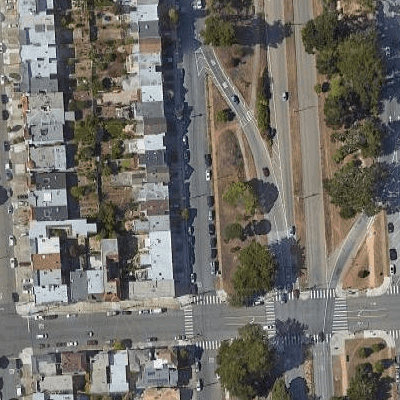

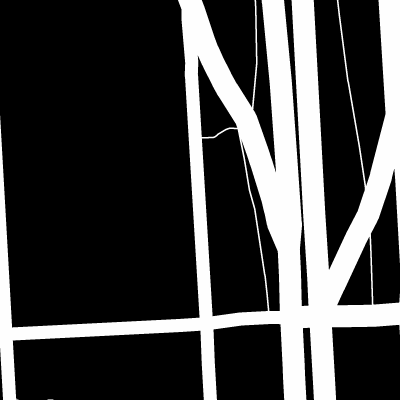

In [5]:
x, y = pick_random_center(cities_boxes)
sat, mask = download_map_sample(y, x)
display(sat)
display(mask)

In [6]:
from skimage.io import imsave
from pathlib import Path

dataset_directory = os.getenv('DATASET_DIR', "../gmaps_dataset/")

def save_image(name, image, mask, img_path, mask_path):
    imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
    # the following removes anti-aliasing
    mask_arrray = (np.array(mask.convert('RGB')).astype(bool)*255)
    imsave(mask_path, mask_arrray.astype(np.uint8))

def download_dataset(dataset_sources, seed, force_download=False):
    np.random.seed(seed)
    Path(os.path.join(dataset_directory, "images")).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(dataset_directory, "masks")).mkdir(parents=True, exist_ok=True)
    for name, city_boxes, count in dataset_sources:
        for i in range(count):
            x, y = pick_random_center_from_city(city_boxes)
            print(x, y)
            img_path = os.path.join(dataset_directory, "images", "{}_{}.png".format(name, i+1))
            mask_path = os.path.join(dataset_directory, "masks", "{}_{}.png".format(name, i+1))
            
            if (os.path.isfile(img_path) and os.path.isfile(mask_path)) and (not force_download):
                print("Already exists: {}_{}.png".format(name, i+1))
            else:
                sat, mask = download_map_sample(y, x)
                save_image(name, sat, mask, img_path, mask_path)
                print("Saved {}_{}.png".format(name, i+1))


In [7]:
dataset_sources = [
    ("los_angeles", los_angeles, 50),
    ("chicago", chicago, 50),
    ("houston", houston, 50),
    ("phoenix", phoenix, 50),
    ("philadelphia", philadelphia, 50),
    ("san_francisco", san_francisco, 50),
    ("boston", boston, 50),
]
download_dataset(dataset_sources, seed=42)

-117.80453619051754 33.700177345604914
Already exists: los_angeles_1.png
-118.46484942512265 34.225470307014724
Already exists: los_angeles_2.png
-118.0167790147759 33.64664905781895
Already exists: los_angeles_3.png
-118.02755674874096 33.63851612777079
Already exists: los_angeles_4.png
-118.25656280383335 34.045420129841936
Already exists: los_angeles_5.png
-118.46003241713213 34.20918342657684
Already exists: los_angeles_6.png
-118.50335147704745 34.24065547384975
Already exists: los_angeles_7.png
-117.9185477585364 33.71090031867273
Already exists: los_angeles_8.png
-117.90239255762623 33.65299963427486
Already exists: los_angeles_9.png
-117.92354845170394 33.63747173209097
Already exists: los_angeles_10.png
-118.59335675763813 34.20958694464624
Already exists: los_angeles_11.png
-118.49901943465015 34.26795711551488
Already exists: los_angeles_12.png
-118.37874623291775 34.189859212468
Already exists: los_angeles_13.png
-118.60047419943163 34.24658160844739
Already exists: los_ang

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddedec99-c003-49f8-9064-90484ffbe195' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>